<a href="https://colab.research.google.com/github/kshitijmamgain/Higgs/blob/master/LGBM_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 8.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 112kB 24.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=308f49443a9eb9b956e0e6d7eba673dc2148a6d992010842abe85bf8bc39815c
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.3.0-cp36-none-any.whl size=221121 sha256=57787dfe6ca6adf38c0708b147b43b900514ed8329040278f8518f668659dd15
  Stored in directory: /root/.cache/pip/wheels/62/fd

In [0]:
# import dependent libraries

'''
#reference links
Hyperopt and Randomsearch with early stopping https://github.com/WillKoehrsen/hyperparameter-optimization 
Optuna tuner https://github.com/optuna/optuna/blob/master/examples/lightgbm_tuner_simple.py
Example for creating hyperopt class https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

'''

import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV

import csv
from timeit import default_timer as timer
from hyperopt import STATUS_OK, STATUS_FAIL, hp, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample
import random

import optuna.integration.lightgbm as lgbo
import optuna


In [0]:
# starting with storing the data as data frame
df = pd.read_csv("drive/My Drive/Colab Notebooks/train_test_files_sample.csv")
df.drop( columns='Unnamed: 0', inplace =True)

# making a smaller df for quick testing
df_s, _ = train_test_split(df, random_state = 30, train_size = 0.01)

train_X = df_s.drop(columns = '0')
train_y = df_s['0']

In [0]:
# drop last columns

def col_keep(df):
  return df.drop(columns = list(map(str,range(22,29))), inplace = True) # removing 7 last columns


In [0]:
MAX_EVALS = 1000
N_FOLDS = 3
NUM_BOOST_ROUNDS = 10000
EARLY_STOPPING_ROUNDS = 100
SEED = 47
N_FOLDS = 3

# Hyperopt

In [0]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf', 
                           'max_bin', 'bagging_freq']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = ['auc','binary','xentropy'], seed = 50,
                        )
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}


# Hyperopt Space
space = {              
            'num_leaves': hp.quniform('num_leaves', 16, 196, 4),

            'max_bin' : hp.quniform('max_bin', 253, 254, 1), #if using CPU just set this to 254

            'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
            
            'lambda_l2': hp.uniform("lambda_l2", 0.0, 1.0),
            
            'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 20, 500, 10),

            'class_weight': hp.choice('class_weight', [None, 'balanced']),
            
            'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                         #{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                         {'boosting_type': 'goss', 'subsample': 1.0}]),

            'learning_rate' : hp.loguniform('learning_rate', np.log(0.05), np.log(0.25)),

            'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),

            'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
                     
            'bagging_freq': hp.uniform('bagging_freq', 1, 7),
                     
            'verbosity' : 0,
            
            }

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

# Global variable
global  ITERATION

ITERATION = 0

train_set = lgb.Dataset(data=train_X, label = train_y)

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

  1%|          | 10/1000 [00:13<22:23,  1.36s/it, best loss: 0.22313642472743256]


KeyboardInterrupt: ignored

In [0]:
bayes_trials.best_trial['result']['params']
bayes_trials.best_trial['result']['estimators']

{'estimators': 40,
 'iteration': 1,
 'loss': 0.22313642472743256,
 'params': {'bagging_freq': 2,
  'boosting_type': 'gbdt',
  'class_weight': 'balanced',
  'feature_fraction': 0.925984858968721,
  'lambda_l1': 0.8546268615947283,
  'lambda_l2': 0.20851241909379892,
  'learning_rate': 0.08279997609106177,
  'max_bin': 254,
  'min_data_in_leaf': 310,
  'num_leaves': 120,
  'subsample': 0.9071514063207494,
  'subsample_for_bin': 300000,
  'verbosity': 0},
 'status': 'ok',
 'train_time': 1.7581046000013885}

In [0]:
params = {'bagging_freq': 2,
  'boosting_type': 'gbdt',
  'class_weight': 'balanced',
  'feature_fraction': 0.925984858968721,
  'lambda_l1': 0.9576268615947283,
  'lambda_l2': 0.20851241909379892,
  'learning_rate': 0.1,
  'max_bin': 254,
  'min_data_in_leaf': 310,
  'num_leaves': 120,
  'subsample': 0.9071514063207494,
  'subsample_for_bin': 300000,
  'verbosity': 0,
  'metrics' : 'auc',
  'objective': 'binary'}
model = lgb.train(params,train_set= train_set, num_boost_round = 1000)

In [0]:

 # DF, based on which importance is checked
import shap
x_test=train_X

explainer=shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


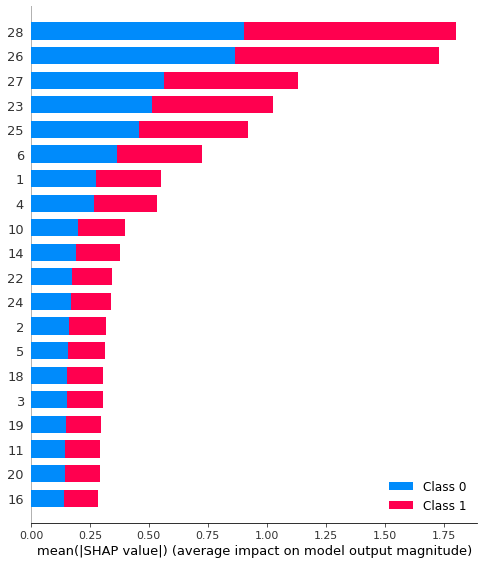

In [0]:
shap.summary_plot(shap_values, train_X)

In [0]:

params = {'bootstrap_type': 'Bernoulli', 'border_count': 138.0, 'depth': 4.0,
          'eval_metric': 'F1', 'grow_policy': 'Lossguide', 'l2_leaf_reg': 2.0,
          'learning_rate': 0.08468178635996755, 
          'loss_function': 'Logloss', 'max_leaves': 14.0, 'min_data_in_leaf': 9.0, 'od_type': 1}
train_set = ctb.Pool(data=train_X, label = train_y)
cv_results = ctb.cv(train_set, params, num_boost_round = 1000, nfold = 3, 
                        early_stopping_rounds = 1000, seed = 50)

ModuleNotFoundError: ignored

In [0]:
print(np.max(cv_results['test-F1-mean']))
print(np.argmax(cv_results['test-F1-mean']))
pd.DataFrame(cv_results)

0.7333060600542517
132


,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.683502,0.023205,0.696027,0.019730,0.682108,0.002251,0.681186,0.001861
1,1,0.688728,0.011828,0.700626,0.010608,0.672861,0.002022,0.671346,0.002089
2,2,0.687624,0.009106,0.701003,0.005980,0.666788,0.002752,0.664724,0.002479
3,3,0.688000,0.007217,0.698298,0.005713,0.660076,0.003203,0.657658,0.003199
4,4,0.688446,0.010935,0.700512,0.011805,0.654133,0.003514,0.650909,0.003697
...,...,...,...,...,...,...,...,...,...
995,995,0.726724,0.004314,0.980006,0.000695,0.582574,0.008190,0.204342,0.002590
996,996,0.726837,0.003508,0.980006,0.000695,0.582591,0.008141,0.204164,0.002561
997,997,0.726568,0.003321,0.980095,0.000647,0.582599,0.008149,0.204024,0.002589
998,998,0.727394,0.003482,0.980051,0.000604,0.582647,0.008197,0.203839,0.002549


# Random Search

In [0]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    # Subsampling (only applicable with 'goss')
    subsample_dist = list(np.linspace(0.5, 1, 100))

    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]    

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 1000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = ['auc','binary','xentropy'], seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

# Hyperparameter grid
param_grid = {
                'num_leaves': list(range(16, 196, 4)),
              
                'max_bin': [254],

                'lambda_l1': list(np.linspace(0, 1)),

                'lambda_l2': list(np.linspace(0, 1)),

                'min_data_in_leaf' : list(range(20, 500, 10)),

                'class_weight': [None, 'balanced'],

                'boosting_type': ['gbdt', 'goss'],
              
                'learning_rate' : list(np.logspace(np.log(0.05), np.log(0.2), base = np.exp(1), num = 1000)),

                'feature_fraction': list(np.linspace(0.4, 1.0)),

                'bagging_freq': list(range(1,7)),

                'verbosity' : [0],

                'objective' : ['binary'],

                }

random.seed(50)

# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))
train_set = lgb.Dataset(data=train_X, label = train_y)
# Iterate through the specified number of evaluations
for i in range(15):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)  
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

{'num_leaves': 140, 'max_bin': 254, 'lambda_l1': 0.4693877551020408, 'lambda_l2': 0.8163265306122448, 'min_data_in_leaf': 170, 'class_weight': 'balanced', 'boosting_type': 'goss', 'learning_rate': 0.05641591746163987, 'feature_fraction': 0.8163265306122449, 'bagging_freq': 3, 'verbosity': 0, 'objective': 'cross_entropy'}
{'num_leaves': 52, 'max_bin': 254, 'lambda_l1': 0.12244897959183673, 'lambda_l2': 0.44897959183673464, 'min_data_in_leaf': 220, 'class_weight': None, 'boosting_type': 'gbdt', 'learning_rate': 0.055100607882570256, 'feature_fraction': 0.6571428571428571, 'bagging_freq': 5, 'verbosity': 0, 'objective': 'cross_entropy'}
{'num_leaves': 192, 'max_bin': 254, 'lambda_l1': 0.8979591836734693, 'lambda_l2': 0.836734693877551, 'min_data_in_leaf': 290, 'class_weight': None, 'boosting_type': 'gbdt', 'learning_rate': 0.08070280316669395, 'feature_fraction': 0.6081632653061224, 'bagging_freq': 4, 'verbosity': 0, 'objective': 'cross_entropy'}
{'num_leaves': 84, 'max_bin': 254, 'lambda

In [0]:
random_results

,loss,params,iteration,estimators,time
0,0.223723,"{'num_leaves': 140, 'max_bin': 254, 'lambda_l1...",0,263,3.17838
1,0.217815,"{'num_leaves': 52, 'max_bin': 254, 'lambda_l1'...",1,232,2.99179
2,0.21802,"{'num_leaves': 192, 'max_bin': 254, 'lambda_l1...",2,220,3.09877
3,0.218454,"{'num_leaves': 84, 'max_bin': 254, 'lambda_l1'...",3,148,2.26455
4,0.22306,"{'num_leaves': 148, 'max_bin': 254, 'lambda_l1...",4,129,2.03518
5,0.218621,"{'num_leaves': 16, 'max_bin': 254, 'lambda_l1'...",5,71,1.49959
6,0.218017,"{'num_leaves': 76, 'max_bin': 254, 'lambda_l1'...",6,117,1.88027
7,0.228988,"{'num_leaves': 160, 'max_bin': 254, 'lambda_l1...",7,352,3.08346
8,0.215102,"{'num_leaves': 128, 'max_bin': 254, 'lambda_l1...",8,131,2.48449
9,0.220214,"{'num_leaves': 36, 'max_bin': 254, 'lambda_l1'...",9,69,3.05208


# Optuna

In [0]:
def objective(trial):
    
    dtrain = lgbo.Dataset(train_X, label=train_y)

    global ITERATION_O

    ITERATION_O += 1

    param ={              
            'num_leaves': trial.suggest_int('num_leaves', 16, 196, 4),

            'max_bin' : trial.suggest_discrete_uniform('max_bin', 63, 255,64), #if using CPU just set this to 254

            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            
            'lambda_l2': trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            
            'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 500),

            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
            
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']), # removed 'dart'

            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.05, 0.25),

            'feature_fraction': trial.suggest_uniform("feature_fraction", 0.4, 1.0),
                
            'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
                     
            'verbosity' : 0

        }
    
    start = timer()

        # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'min_data_in_leaf', 
                           'max_bin', 'bagging_freq']:
        param[parameter_name] = int(param[parameter_name])

    # Perform n_folds cross validation
    if param['boosting_type'] == 'goss':
      param['subsample'] = 1
    else:
      param['subsample'] = trial.suggest_uniform('subsample', 0.5, 1)
    
    cv_results = lgb.cv(param, dtrain, num_boost_round = 10000, nfold = 3, 
                        early_stopping_rounds = 100, metrics = ['auc','binary','xentropy'], 
                        seed = 50,
                        )
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])

    loss = 1 - best_score

    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, param, ITERATION_O, n_estimators, run_time])

    
    return loss

# Global variable
global  ITERATION_O

ITERATION_O = 0

# File to save first results
out_file = 'gbm_optuna.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=100)

[I 2020-04-06 19:52:41,739] Finished trial#0 with value: 0.23937060412755595 with parameters: {'num_leaves': 108, 'max_bin': 191.0, 'lambda_l1': 0.09268139426113875, 'lambda_l2': 6.36355407290065, 'min_data_in_leaf': 105, 'class_weight': 'balanced', 'boosting_type': 'goss', 'learning_rate': 0.19774658176662815, 'feature_fraction': 0.709128398650851, 'bagging_freq': 6}. Best is trial#0 with value: 0.23937060412755595.
[I 2020-04-06 19:52:42,895] Finished trial#1 with value: 0.24001519622309075 with parameters: {'num_leaves': 140, 'max_bin': 255.0, 'lambda_l1': 7.89492562093299e-05, 'lambda_l2': 0.007971569858429745, 'min_data_in_leaf': 142, 'class_weight': None, 'boosting_type': 'goss', 'learning_rate': 0.08620222449969922, 'feature_fraction': 0.9416601400713059, 'bagging_freq': 1}. Best is trial#0 with value: 0.23937060412755595.
[I 2020-04-06 19:52:44,499] Finished trial#2 with value: 0.2285245843880035 with parameters: {'num_leaves': 192, 'max_bin': 63.0, 'lambda_l1': 0.0046712462857

# LGBM Class with PEP8

In [0]:
!pip install optuna
!pip install shap

In [0]:

# coding: utf-8
''' This class tunes hyperparamter for LightGBM ML algorithm for Higgs dataset'''
import csv
from timeit import default_timer as timer
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from hyperopt import STATUS_OK, STATUS_FAIL, hp, tpe, Trials, fmin
import optuna.integration.lightgbm as lgbo
import optuna
import matplotlib.pyplot as plt
import shap


# defining constant
MAX_EVALS = 5
N_FOLDS = 3
NUM_BOOST_ROUNDS = 10000
EARLY_STOPPING_ROUNDS = 100
SEED = 47
RESULT_PATH = '/content/lgbm.csv'
FILE_PATH = "drive/My Drive/Colab Notebooks/train_test_files_sample.csv" 
OBJECTIVE_LOSS = 'binary' # use cross_entrpy
# "/home/jupyter/train_test_files/sample.csv" for google cloud

# starting with storing the data as data frame
df = pd.read_csv(FILE_PATH)
df.drop(columns='Unnamed: 0', inplace=True)

# making a smaller df for quick testing
df_s, _ = train_test_split(df, random_state=30, train_size=0.01)
train_X = df_s.drop(columns='0')
train_y = df_s['0']

# drop last columns
def col_keep(df):
    '''Removes the last 7 columns'''
    return df.drop(columns=list(map(str, range(22, 29))), inplace=True) # removing 7 last columns


In [0]:


# random search
PARAM_GRID = {
    'num_leaves': list(range(16, 196, 4)),
    'max_bin': [254],
    'lambda_l1': list(np.linspace(0, 1)),
    'lambda_l2': list(np.linspace(0, 1)),
    'min_data_in_leaf' : list(range(20, 500, 10)),
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss'],
    'learning_rate' : list(np.logspace(np.log(0.05), np.log(0.2), base=np.exp(1), num=1000)),
    'feature_fraction': list(np.linspace(0.4, 1.0)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'bagging_freq': list(range(1, 7)),
    'verbosity' : [0],
    'objective' : [OBJECTIVE_LOSS]
    }


# Hyperopt Space
H_SPACE = {
    'num_leaves': hp.quniform('num_leaves', 16, 196, 4),
    'max_bin' : hp.quniform('max_bin', 253, 254, 1), #if using CPU just set this to 254
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform("lambda_l2", 0.0, 1.0),
    'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 20, 500, 10),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type',
                               [{'boosting_type': 'gbdt',
                                 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)},
                                #{'boosting_type': 'dart',
                                #'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                {'boosting_type': 'goss', 'subsample': 1.0}]),
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.05), np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
    'bagging_freq': hp.uniform('bagging_freq', 1, 7),
    'verbosity' : 0,
    'objective' : OBJECTIVE_LOSS
    }

class Lgbmclass():
    '''Parameter Tuning Class tunes the LightGBM model with different optimization techniques -
    Hyperopt, Optuna and RandomSearch. At present method for CV using Hyperopt is defined'''
    iteration = 0
    def __init__(self, x_train, y_train):
        '''Initializes the Parameter tuning class and also initializes LightGBM dataset object
        Parameters
        ----------
        x_train: data (string, numpy array, pandas DataFrame, H2O DataTable's Frame, scipy.sparse
        or list of numpy arrays) – Data source of Dataset. If string, it represents the path to
        txt file.
        y_train: label (list, numpy 1-D array, pandas Series / one-column DataFrame or None,
        optional (default=None)) – Label of the data.'''

        

        # File to save first results
        self.out_file = RESULT_PATH
        of_connection = open(self.out_file, 'w')
        writer = csv.writer(of_connection)

        # Write the headers to the file
        writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time','optim_type'])
        of_connection.close()

        self.x_train = x_train
        self.y_train = y_train
        self.train_set = lgb.Dataset(data=train_X, label=train_y)

    def lgb_crossval(self, params, optim_type):
        '''lgb cross validation model
        Paramters
        ---------
        params: Hyper parameters in dict type from different optimization methods
        optim_type: Is the type of optimization called we use lgb integration for optuna type
        Returns
        ------
        Loss, params, n_estimator, run_time'''
        # initializing the timer
         
        start = timer()
        if optim_type == 'optuna':
            cv_results = lgbo.cv(params, self.train_set, num_boost_round=NUM_BOOST_ROUNDS,
                                 nfold=N_FOLDS, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                 metrics=['auc', 'binary', 'xentropy'], seed=SEED)
        else:
            cv_results = lgb.cv(params, self.train_set, num_boost_round=NUM_BOOST_ROUNDS,
                                nfold=N_FOLDS, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                metrics=['auc', 'binary', 'xentropy'], seed=SEED)
        # store the runtime
        run_time = timer() - start

        # Extract the best score
        best_score = np.max(cv_results['auc-mean'])

        # Loss must be minimized
        loss = 1 - best_score

        # Boosting rounds that returned the highest cv score
        n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
        self.estimator = n_estimators

        # Write to the csv file ('a' means append)
        of_connection = open(self.out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, self.iteration, n_estimators, run_time, optim_type])

        print(cv_results)       
        return loss, params, n_estimators, run_time

    def parameter_tuning(self, tune_type):
        tuner = getattr(self, tune_type)
        return(tuner())

    def hyperopt_space(self):
        '''A method to call the hyperopt optimization for the data
        Parameters
        ----------
        fn_name: is the objective function to minimize defined with in the class function
        space: is dictionary type hypeorpt space over which the search is done
        algo: is the type of search algorithm
        trials: Hyperopt base trials object
        Returns
        -------
        result: best parameter that minimizes the fn_name over max_evals = 50 FIXED FOR TESTING
        trials: the database in which to store all the point evaluations of the search'''
        fn_name, space, algo, trials='hyperopt_obj', H_SPACE, tpe.suggest, Trials()
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=MAX_EVALS,
                          trials=trials, rstate=np.random.RandomState(50))
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        self.params = trials.best_trial['result']['params']
        self.params['n_estimator'] = self.estimator
        return result, trials

    def optuna_space(self):
        '''Optuna search space'''
        fn_name = 'optuna_obj'
        fn = getattr(self, fn_name)
        try:
            study = optuna.create_study(direction='minimize')
            study.optimize(fn, n_trials=5)
        except Exception as e:
            return {'exception': str(e)}
        self.params = study.best_params
        self.params['n_estimator'] = self.estimator
        return study

    def random_space(self):
        '''Random search space'''
        # Dataframe to hold cv results
        space = PARAM_GRID
        random_results = pd.DataFrame(columns=['loss', 'params', 'iteration', 'estimators',
                                               'time'], index=list(range(MAX_EVALS)))

        # Iterate through the specified number of evaluations
        for i in range(MAX_EVALS):

            # Randomly sample parameters for gbm
            params = {key: random.sample(value, 1)[0] for key, value in space.items()}
            results_list = self.randomsrch_obj(params, i)

            # Add results to next row in dataframe
            random_results.loc[i, :] = results_list
        #sort values by the loss
        random_results.sort_values('loss', ascending = True, inplace = True)
        self.params = random_results.loc[0, 'params']
        self.params['n_estimator'] = self.estimator
        return random_results

    def hyperopt_obj(self, params):
        """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""

        optim_type = 'Hyperopt'
        self.iteration += 1

        # Retrieve the subsample if present otherwise set to 1.0
        subsample = params['boosting_type'].get('subsample', 1.0)

        # Extract the boosting type
        params['boosting_type'] = params['boosting_type']['boosting_type']
        params['subsample'] = subsample

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            params[parameter_name] = int(params[parameter_name])

        # Perform n_folds cross validation
        loss, params, n_estimators, run_time = self.lgb_crossval(params, optim_type)

        # Dictionary with information for evaluation
        return {'loss':loss, 'params':params, 'iteration':self.iteration,
                'estimators':n_estimators, 'train_time':run_time, 'status':STATUS_OK}

    def optuna_obj(self, trial):
        '''Defining the parameters space inside the function for optuna optimization'''
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 16, 196, 4),
            'max_bin' : trial.suggest_int('max_bin', 63, 255, 64),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 500),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
            # removed 'dart'
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.05, 0.25),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin',20000, 300000, 20000),
            'feature_fraction': trial.suggest_uniform("feature_fraction", 0.4, 1.0),
            'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
            'verbosity' : 0,
            'objective' : OBJECTIVE_LOSS
                }

        optim_type = 'Optuna'
        self.iteration += 1

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            params[parameter_name] = int(params[parameter_name])

        # Perform n_folds cross validation
        if params['boosting_type'] == 'goss':
            params['subsample'] = 1
        else:
            params['subsample'] = trial.suggest_uniform('subsample', 0.5, 1)

        loss, params, _, _ = self.lgb_crossval(params, optim_type)

        return loss

    def randomsrch_obj(self, params, iteration):
        """Random search objective function. Takes in hyperparameters and returns a list
        of results to be saved."""
        optim_type = 'Random'
        self.iteration += 1

        # Subsampling (only applicable with 'goss')
        subsample_dist = list(np.linspace(0.5, 1, 100))

        if params['boosting_type'] == 'goss':
            # Cannot subsample with goss
            params['subsample'] = 1.0
        else:
            # Subsample supported for gdbt and dart
            params['subsample'] = random.sample(subsample_dist, 1)[0]

        # Perform n_folds cross validation
        loss, params, n_estimators, run_time = self.lgb_crossval(params, optim_type)

        # Return list of results
        return [loss, params, iteration, n_estimators, run_time]

    def train(self, x_test, y_test):
        """This function evaluates the model on paramters and estimators
        Parameters
        ----------
        x_test: test set; y_test: test label"""
        self.test_X, self.test_y = x_test, y_test
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            self.params[parameter_name] = int(self.params[parameter_name])
        self.gbm = lgb.train(self.params, self.train_set,
                             feature_name=['f' + str(i + 1) for i in range(train_X.shape[-1])])
        self.pred = self.gbm.predict(x_test)
        
        print("Model will be trained with best parameters obtained from Hyperopt ... \n\n\n")
        print("Model trained with {} estimators on the following parameters: \n{}".format(self.estimator, self.params))

    def evaluate(self):
        """This function generates the evaluation report for the model"""
        pred = self.pred
        print('check pred')
        (self.fpr, self.tpr, self.thresholds) = roc_curve(y_true=self.test_y, y_score=pred)
        print('fpr, tpr, thresh check')
        self.fnr = 1- self.tpr
        print('fnr check')
        self.roc_auc = auc(self.fpr, self.tpr)
        print('roc_Auc check')
        self.precision, self.recall, _ = precision_recall_curve(self.test_y, pred)
        print('precision recall check')
        self.pr_auc = auc(self.recall, self.precision)
        print('pr_acu check')
        eval_list = ['feature_importance','roc', 'prcurve', 'fpr_fnr']
        for eval_name in eval_list:
            func = getattr(self,eval_name)
            func()
        else:
            print('Not valid evaluation type')

    def feature_importance(self):
        print('Plotting feature importances...')
        ax = lgb.plot_importance(self.gbm, max_num_features=10)
        plt.savefig('feature_importance.png')
    
    def shap_features(self):
        # DF, based on which importance is checked
        
        X_importance = self.test_X

        # Explain model predictions using shap library:
        explainer = shap.TreeExplainer(self.lgbm)
        shap_values = explainer.shap_values(X_importance)
        # Plot summary_plot
        plt.figure()
        shap.summary_plot(shap_values, X_importance)
        

    def roc(self):
        fpr, tpr, roc = self.fpr, self.tpr, self.roc_auc

        plt.figure(figsize=(16, 8))
        lw = 2

        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % self.roc_auc, alpha=0.5)

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('Receiver operating characteristic', fontsize=20)
        plt.legend(loc="lower right", fontsize=16)
        plt.savefig('roc.png')
        
    def prcurve(self):
        recall, precision, pr_auc = self.recall, self.precision, self.pr_auc
        test_y = self.test_y
        # plot the precision-recall curves
        no_skill = len(test_y[test_y==1]) / len(test_y)
        plt.figure(figsize = (16,8))
        plt.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--',
                 alpha=0.5)
        plt.plot(recall, precision, color='darkorange',
                 label='ROC curve (area = %0.2f)'% pr_auc, alpha=0.5)
        # axis labels
        plt.title('Precision Recall Curve', size = 20)
        plt.xlabel('Recall', fontsize=16)
        plt.ylabel('Precision', fontsize=16)
        plt.grid(True)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        # show the legend
        plt.legend(fontsize=16)
        plt.savefig('prcurve.png')
    def fpr_fnr(self):
        lw = 2
        fpr, fnr, thresholds = self.fpr, self.fnr, self.thresholds
        plt.figure(figsize = (16,8))
        plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
        plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('Threshold', fontsize=16)
        plt.ylabel('Error Rate', fontsize=16)
        plt.title('FPR-FNR curves', fontsize=20)
        plt.legend(loc="lower left", fontsize=16)
        plt.savefig('fpr-fnr.png')



obj = Lgbmclass(train_X, train_y)



In [0]:
lgb_ho = obj.parameter_tuning('hyperopt_space')
    

{'xentropy-mean': [0.6791220087258559, 0.6701883655538067, 0.6633069981971181, 0.6553887818795072, 0.6483405319580505, 0.6429440153053508, 0.6383527772547914, 0.6332512347104755, 0.6287150215284408, 0.6245969414663626, 0.6207587302289541, 0.617321569622958, 0.6139699882412705, 0.6109925370408705, 0.6075882639260147, 0.6050314966922862, 0.6023658860502378, 0.6001668428680342, 0.597924123310532, 0.5955549369299982, 0.59333764734243, 0.591248148442959, 0.589654323433202, 0.5875295696304912, 0.5858558757046106, 0.5842263135963824, 0.5830902382744431, 0.58200284611593, 0.5808494563775609, 0.5796776875767359, 0.5785269696215668, 0.5774494980352202, 0.5765875883844686, 0.57545098532367, 0.5745977508452843, 0.5737114939279949, 0.5729920652919261, 0.5722493137677755, 0.5716764033326845, 0.5709928709949416, 0.5703649406000145, 0.5698431118428765, 0.5692968011350126, 0.5687533727627747, 0.5680279220957485, 0.5675760602721002, 0.5671497503114807, 0.5668264415664099, 0.5662624320878229, 0.566034791

In [0]:
obj.train(train_X, train_y)

Model will be trained with best parameters obtained from Hyperopt ... 



Model trained with 72 estimators on the following parameters: 
{'bagging_freq': 2, 'boosting_type': 'gbdt', 'class_weight': 'balanced', 'feature_fraction': 0.925984858968721, 'lambda_l1': 0.8546268615947283, 'lambda_l2': 0.20851241909379892, 'learning_rate': 0.08279997609106177, 'max_bin': 254, 'min_data_in_leaf': 310, 'num_leaves': 120, 'objective': 'binary', 'subsample_for_bin': 300000, 'verbosity': 0, 'subsample': 0.9071514063207494, 'n_estimator': 72}


check pred
fpr, tpr, thresh check
fnr check
roc_Auc check
precision recall check
pr_acu check
Plotting feature importances...
Not valid evaluation type


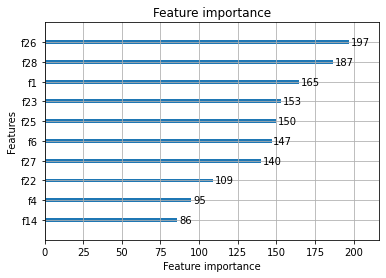

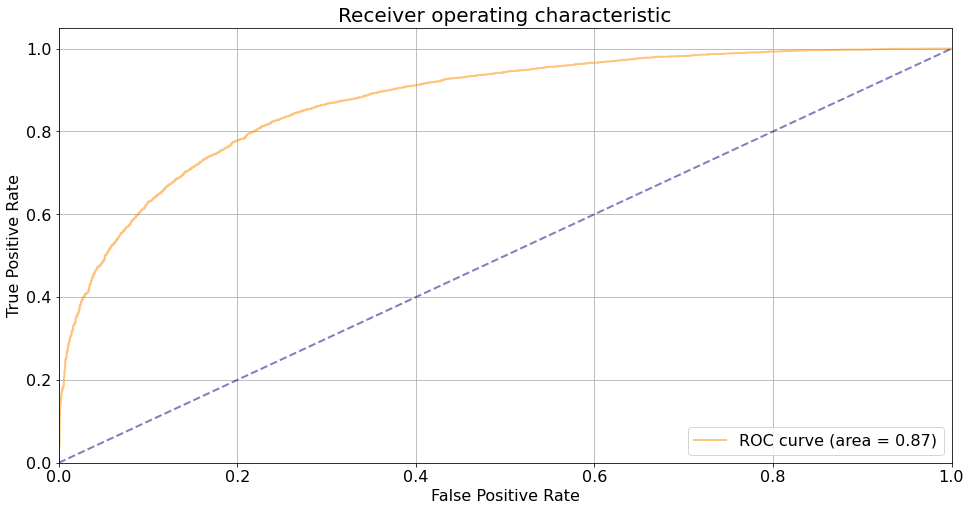

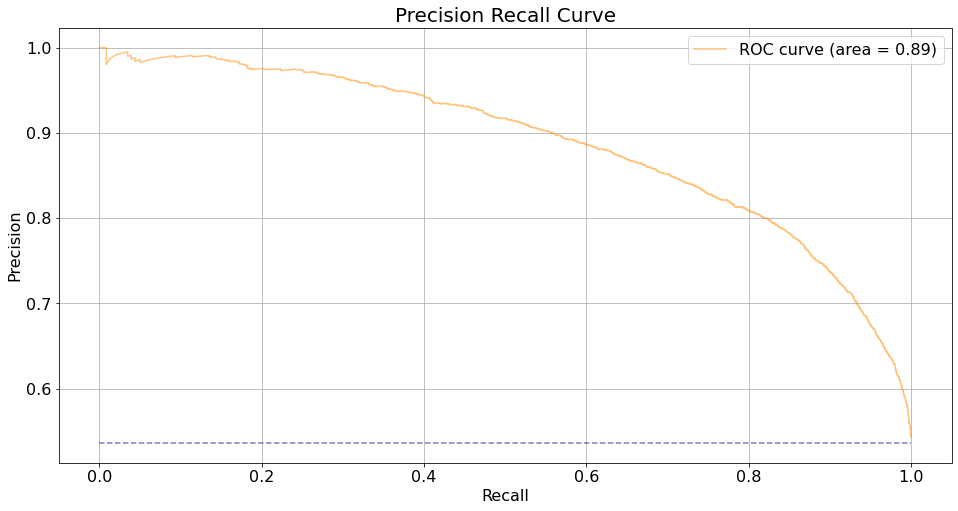

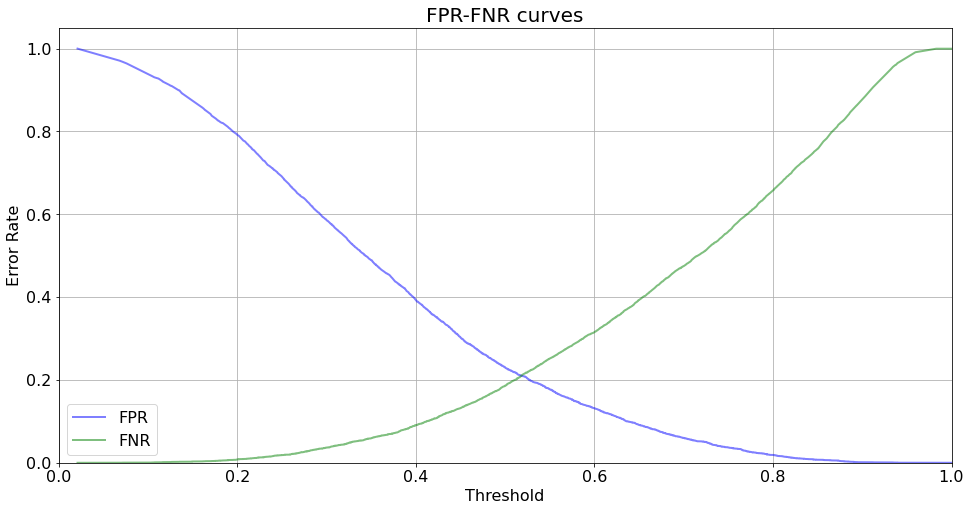

In [0]:
obj.evaluate()    

In [0]:
obj.train(test_X, test_y)

Model will be trained with best parameters obtained from Hyperopt ... 



Model trained with 16 estimators on the following parameters: 
{'num_leaves': 76, 'max_bin': 254, 'lambda_l1': 0.9387755102040816, 'lambda_l2': 0.7755102040816326, 'min_data_in_leaf': 250, 'class_weight': None, 'boosting_type': 'gbdt', 'learning_rate': 0.13617344997266317, 'feature_fraction': 0.7795918367346939, 'subsample_for_bin': 160000, 'bagging_freq': 1, 'verbosity': 0, 'objective': 'binary', 'subsample': 0.7626262626262627, 'n_estimator': 16}


check pred
fpr, tpr, thresh check
fnr check
roc_Auc check
precision recall check
pr_acu check
Plotting feature importances...
Not valid evaluation type


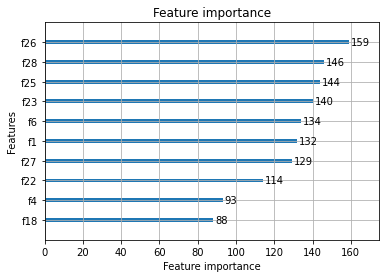

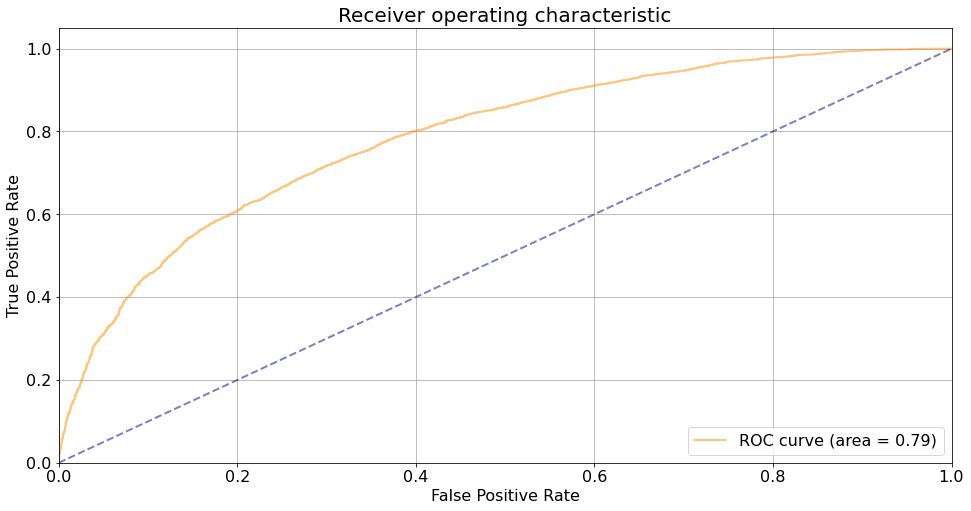

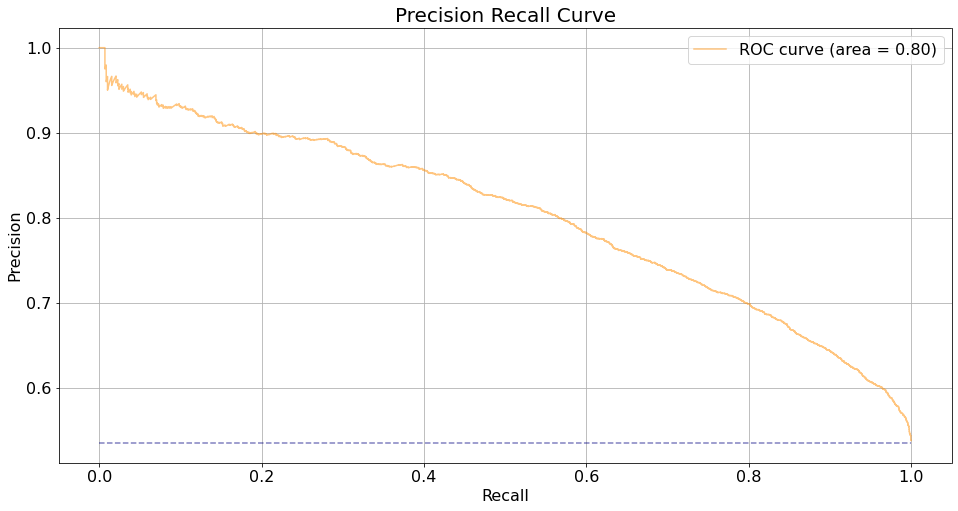

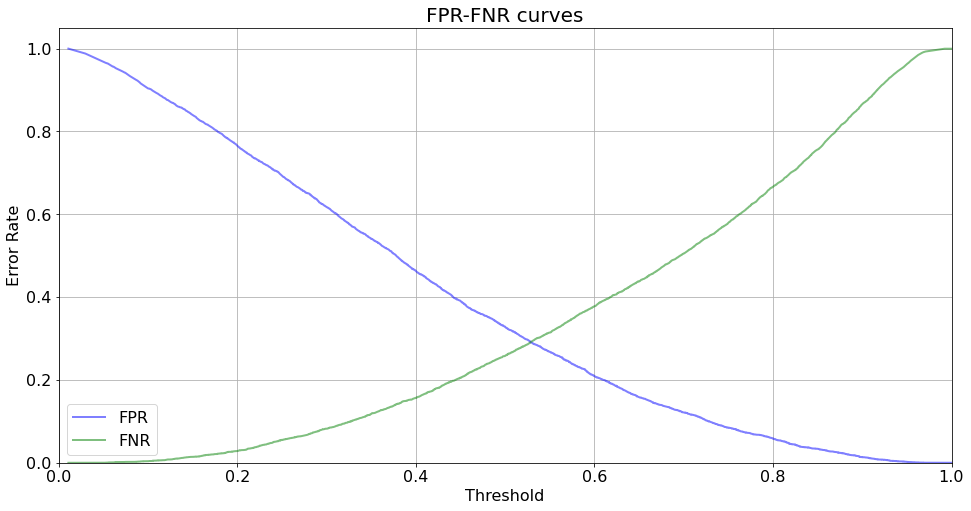

In [0]:

obj.evaluate()

In [0]:
lgb_op = obj.optuna_space('optuna_obj')

[I 2020-04-13 18:47:07,464] Finished trial#0 with value: 0.22583329476285063 with parameters: {'num_leaves': 32, 'max_bin': 63.0, 'lambda_l1': 0.0005361433544000537, 'lambda_l2': 6.162893107015396e-08, 'min_data_in_leaf': 489, 'class_weight': None, 'boosting_type': 'gbdt', 'learning_rate': 0.15279122300891332, 'feature_fraction': 0.9878158478300871, 'bagging_freq': 5, 'subsample': 0.7596675233646017}. Best is trial#0 with value: 0.22583329476285063.
[I 2020-04-13 18:47:09,222] Finished trial#1 with value: 0.22624241542915602 with parameters: {'num_leaves': 72, 'max_bin': 255.0, 'lambda_l1': 0.00021378749659958072, 'lambda_l2': 0.0028804577788386584, 'min_data_in_leaf': 485, 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'learning_rate': 0.14568656311438918, 'feature_fraction': 0.509428616199794, 'bagging_freq': 1, 'subsample': 0.6957269720656425}. Best is trial#0 with value: 0.22583329476285063.
[I 2020-04-13 18:47:11,872] Finished trial#2 with value: 0.21935826813827564 with par

In [0]:
lgb_op.best_params

{'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'feature_fraction': 0.9608478730248725,
 'lambda_l1': 0.0007743491346908428,
 'lambda_l2': 0.7625721461866937,
 'learning_rate': 0.05594193865718806,
 'max_bin': 191.0,
 'min_data_in_leaf': 278,
 'num_leaves': 52,
 'subsample': 0.6208770089314004}

In [0]:
para_T = {'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'feature_fraction': 0.9608478730248725,
 'lambda_l1': 0.0007743491346908428,
 'lambda_l2': 0.7625721461866937,
 'learning_rate': 0.05594193865718806,
 'max_bin': 191.0,
 'min_data_in_leaf': 278,
 'num_leaves': 52,
 'subsample': 0.6208770089314004}

for parameter_name in ['num_leaves', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            para_T[parameter_name] = int(para_T[parameter_name])
cv_results = lgb.cv(para_T, lgb.Dataset(train_X, train_y), num_boost_round=NUM_BOOST_ROUNDS,
                                nfold=N_FOLDS, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                metrics=['auc', 'binary', 'xentropy'], seed=SEED)

In [0]:
cv_results

{'auc-mean': [0.696436951813595,
  0.7045252641038577,
  0.7222350790497939,
  0.7201509599454564,
  0.7188368280379068,
  0.720273455421768,
  0.7261521987965353,
  0.7291912245750763,
  0.7311386783378212,
  0.7321340703413997,
  0.7321018462076134,
  0.732851973709046,
  0.7339685481512266,
  0.7349267374197037,
  0.7355371905347926,
  0.7370002428025565,
  0.7385712377120187,
  0.7421890942808126,
  0.7439467593846362,
  0.7451265784764889,
  0.7466068643641894,
  0.7479415124859491,
  0.748668442987848,
  0.7500931436125148,
  0.7520230902058,
  0.7538343710160932,
  0.7550168708932694,
  0.7560804861478351,
  0.7577971188232381,
  0.7587348465874095,
  0.7598521869682539,
  0.7607337276604414,
  0.7610978220752934,
  0.7616946524241467,
  0.7624976296933849,
  0.7631126237305524,
  0.7637322681096076,
  0.7641864697372709,
  0.7647389303535256,
  0.7654306823867918,
  0.765914317943109,
  0.7665033247756101,
  0.7668575166977365,
  0.7673694372747115,
  0.7678189338505828,
  0.76

In [0]:
int(np.argmax(cv_results['auc-mean']) + 1)

65

In [0]:
np.argmax(cv_results['auc-mean'])

64

In [0]:
import yaml

In [0]:
% cat> test.yml

files:
    location: 'theinputlocation.txt'
    output: 'theoutputlocation.txt'
^C


In [0]:
%cat test.yml

files:
    location: 'theinputlocation.txt'
    output: 'theoutputlocation.txt'


In [0]:
with open('test.yml') as file:
    config = yaml.safe_load(file)

In [0]:
config['files']['location']

'theinputlocation.txt'

# Final Class Test

Running 3 rounds of LGBM parameter optimisation using Optuna:


[I 2020-04-28 19:51:54,077] Finished trial#0 with value: 0.3252160359691376 with parameters: {'num_leaves': 44, 'max_bin': 254, 'lambda_l1': 5.893154810016104, 'lambda_l2': 0.03619192652051383, 'min_data_in_leaf': 356, 'boosting_type': 'goss', 'learning_rate': 0.15615819157003066, 'subsample_for_bin': 160000, 'feature_fraction': 0.9598944782267296, 'bagging_freq': 2}. Best is trial#0 with value: 0.3252160359691376.
[I 2020-04-28 19:52:37,108] Finished trial#1 with value: 0.29443085249549394 with parameters: {'num_leaves': 120, 'max_bin': 254, 'lambda_l1': 1.6589925508379466e-06, 'lambda_l2': 2.01340842555832e-06, 'min_data_in_leaf': 456, 'boosting_type': 'gbdt', 'learning_rate': 0.05861064293264634, 'subsample_for_bin': 200000, 'feature_fraction': 0.8575665949621305, 'bagging_freq': 1, 'subsample': 0.6611039740347395}. Best is trial#1 with value: 0.29443085249549394.
[I 2020-04-28 19:52:49,999] Finished trial#2 with value: 0.3331474941852428 with parameters: {'num_leaves': 152, 'max_bi

Model will be trained with best parameters obtained from Optuna ... 



Model trained with 4 estimators on the following parameters: 
{'num_leaves': 44, 'max_bin': 254, 'lambda_l1': 5.893154810016104, 'lambda_l2': 0.03619192652051383, 'min_data_in_leaf': 356, 'boosting_type': 'goss', 'learning_rate': 0.15615819157003066, 'subsample_for_bin': 160000, 'feature_fraction': 0.9598944782267296, 'bagging_freq': 2, 'verbosity': 0, 'objective': 'binary', 'subsample': 1, 'n_estimator': 51}
check pred
fpr, tpr, thresh check
fnr check
roc_auc check
precision recall check
pr_auc check
Plotting feature importances...


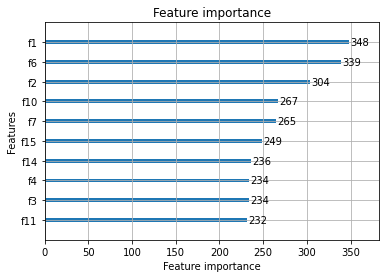

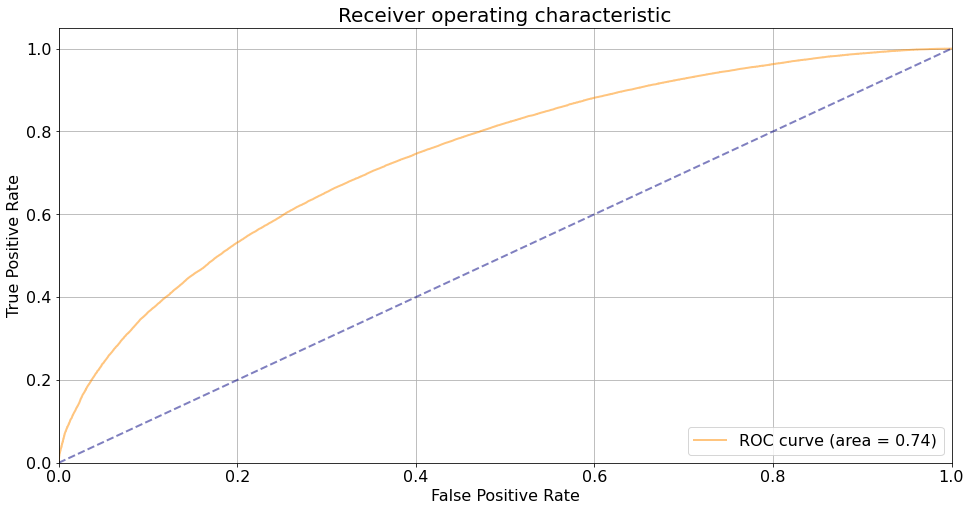

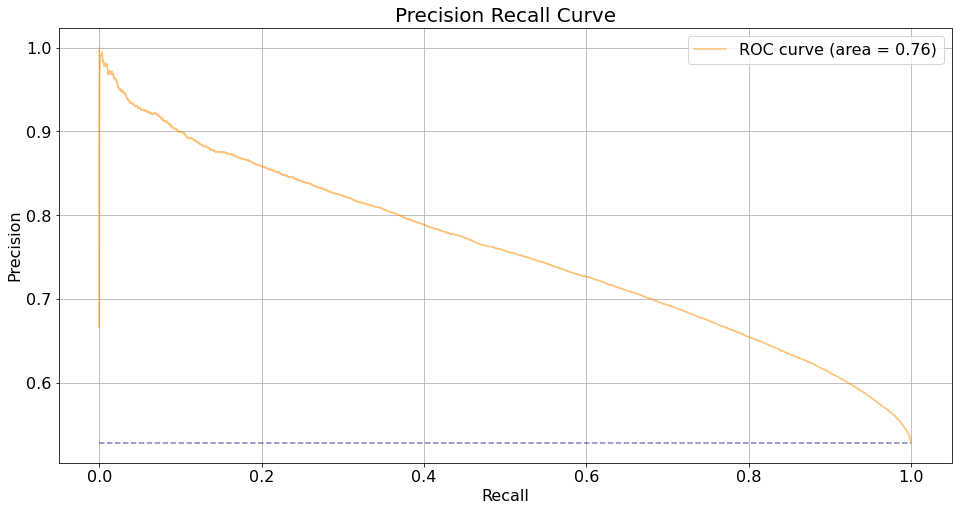

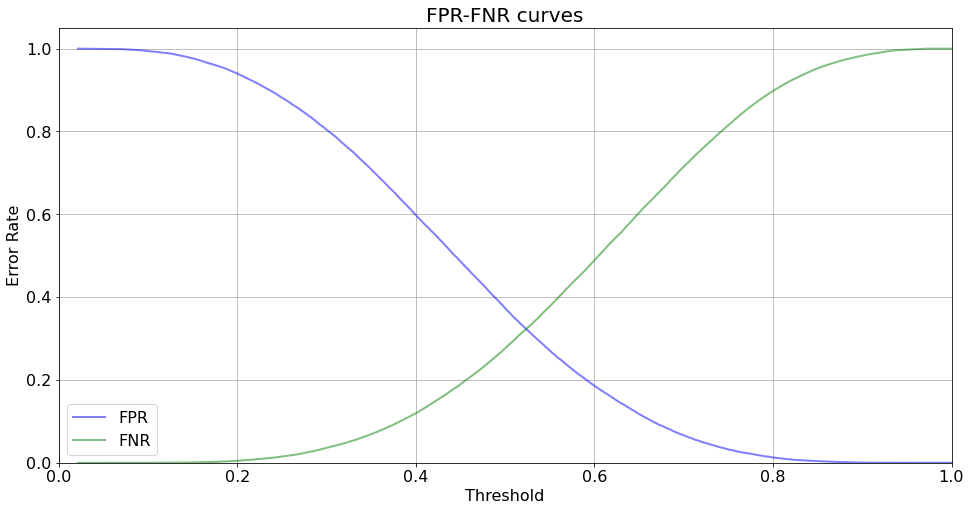

In [26]:

# Draft Codes
# coding: utf-8
''' This class tunes hyperparamter for LightGBM ML algorithm for Higgs dataset'''
import ast 
import csv
from timeit import default_timer as timer
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from hyperopt import STATUS_OK, STATUS_FAIL, hp, tpe, Trials, fmin
import optuna.integration.lightgbm as lgbo
import optuna
import matplotlib.pyplot as plt


# defining constant
MAX_EVALS = 3
N_FOLDS = 3
NUM_BOOST_ROUNDS = 10000
EARLY_STOPPING_ROUNDS = 100
SEED = 47
RESULT_PATH = 'lgbm.csv'
FILE_PATH = "drive/My Drive/Colab Notebooks/train_test_files_sample.csv"
OBJECTIVE_LOSS = 'binary' # use cross_entropy
EVAL_METRIC = ['auc', 'binary', 'xentropy']
#   for google colab

# starting with storing the data as data frame
df = pd.read_csv(FILE_PATH)
df.drop(columns='Unnamed: 0', inplace=True)

# making a smaller df for quick testing
df_s, _ = train_test_split(df, random_state=30, train_size=0.1)
train_X = df_s.drop(columns='0')
train_y = df_s['0']

# drop last columns
def col_keep(df):
    '''Removes the last 7 columns'''
    return df.drop(columns=list(map(str, range(22, 29))), inplace=True) # removing 7 last columns
col_keep(train_X)

# random search
PARAM_GRID = {
    'num_leaves': list(range(16, 196, 4)),
    'max_bin': [254],
    'lambda_l1': list(np.linspace(0, 1)),
    'lambda_l2': list(np.linspace(0, 1)),
    'min_data_in_leaf' : list(range(20, 500, 10)),
    'boosting_type': ['gbdt', 'goss'],
    'learning_rate' : list(np.logspace(np.log(0.05), np.log(0.2), base=np.exp(1), num=1000)),
    'feature_fraction': list(np.linspace(0.4, 1.0)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'bagging_freq': list(range(1, 7)),
    'verbosity' : [0],
    'objective' : [OBJECTIVE_LOSS]
    }


# Hyperopt Space
H_SPACE = {
    'num_leaves': hp.quniform('num_leaves', 16, 196, 4),
    'max_bin' : hp.quniform('max_bin', 253, 254, 1), #if using CPU just set this to 254
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform("lambda_l2", 0.0, 1.0),
    'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 20, 500, 10),
    'boosting_type': hp.choice('boosting_type',
                               [{'boosting_type': 'gbdt',
                                 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)},
                                #{'boosting_type': 'dart',
                                #'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                {'boosting_type': 'goss', 'subsample': 1.0}]),
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.05), np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
    'bagging_freq': hp.uniform('bagging_freq', 1, 7),
    'verbosity' : 0,
    'objective' : OBJECTIVE_LOSS
    }

class Lgbmclass():
    '''Parameter Tuning Class tunes the LightGBM model with different optimization techniques -
    Hyperopt, Optuna and RandomSearch.'''
    iteration = 0
    def __init__(self, x_train, y_train):
        '''Initializes the Parameter tuning class and also initializes LightGBM dataset object
        Parameters
        ----------
        x_train: data (string, numpy array, pandas DataFrame, H2O DataTable's Frame, scipy.sparse
        or list of numpy arrays) – Data source of Dataset. If string, it represents the path to
        txt file.
        y_train: label (list, numpy 1-D array, pandas Series / one-column DataFrame or None,
        optional (default=None)) – Label of the data.'''

        

        # File to save first results
        self.out_file = RESULT_PATH
        with open(self.out_file, 'w', newline='') as of_connection:
            writer = csv.writer(of_connection)
            # Write the headers to the file
            writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time','optim_type'])

        self.x_train = x_train
        self.y_train = y_train
        self.train_set = lgb.Dataset(data=train_X, label=train_y)

    def parameter_tuning(self, tune_type, diagnostic=False):
        '''
        '''
        methodlist = ['hypeopt_space','optuna_space','random_space']
        optim_type = 'random_space'
        if optim_type not in methodlist:
            raise TypeError('Otimization type must have a valid space:',
                            '\n\t\t hyperopt_space, optuna_space or random_space')
        tuner = getattr(self, tune_type)
        if diagnostic:
            return(tuner())
        else:
            tuner()
            return self.params

    def lgb_crossval(self, params, optim_type):
        '''lgb cross validation model
        Paramters
        ---------
        params: Hyper parameters in dict type from different optimization methods
        optim_type: Is the type of optimization called we use lgb integration for optuna type
        Returns
        ------
        Loss, params, n_estimator, run_time'''
        # initializing the timer
         
        start = timer()
        if optim_type == 'optuna':
            cv_results = lgbo.cv(params, self.train_set, num_boost_round=NUM_BOOST_ROUNDS,
                                 nfold=N_FOLDS, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                 metrics=EVAL_METRIC, seed=SEED)
        else:
            cv_results = lgb.cv(params, self.train_set, num_boost_round=NUM_BOOST_ROUNDS,
                                nfold=N_FOLDS, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                metrics=EVAL_METRIC, seed=SEED)
        # store the runtime
        run_time = timer() - start

        # Extract the best score
        best_score = np.max(cv_results['auc-mean'])

        # Loss must be minimized
        loss = 1 - best_score

        # Boosting rounds that returned the highest cv score
        n_estimators = int(np.argmax(cv_results['auc-mean']) + 1) # more explanation
        self.estimator = n_estimators

        # Write to the csv file ('a' means append)
        of_connection = open(self.out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, self.iteration, n_estimators, run_time, optim_type])

        return loss, params, n_estimators, run_time

    def hyperopt_space(self):
        '''An Lgbm class method to call the hyperopt optimization for the data
        Parameters
        ----------
        fn_name: is the objective function to minimize defined with in the class function
        space: is dictionary type hypeorpt space over which the search is done
        algo: is the type of search algorithm
        trials: Hyperopt base trials object
        Returns
        -------
        result: best parameter that minimizes the fn_name over max_evals = MAX_EVALS FIXED FOR TESTING
        trials: the database in which to store all the point evaluations of the search'''
        print('Running {} rounds of LGBM parameter optimisation using Hyperopt:'.format(MAX_EVALS))
        fn_name, space, algo, trials='hyperopt_obj', H_SPACE, tpe.suggest, Trials()
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=MAX_EVALS,
                          trials=trials, rstate=np.random.RandomState(SEED))
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        self.params = trials.best_trial['result']['params']
        self.params['n_estimator'] = self.estimator
        return result, trials

    def optuna_space(self):
        '''An Optuna class method to call the Optuna optimization for the data
        Parameters
        ----------
        fn_name: is the optuna objective function to minimize defined with in the class function
        direction: to indicate if the objective function is a loss to be minimized or gain to be maximized
        n_trials: Optuna evaluation roundd
        Returns
        -------
        study: Optuna study object
        '''
        
        print('Running {} rounds of LGBM parameter optimisation using Optuna:'.format(MAX_EVALS))
        fn_name = 'optuna_obj'
        fn = getattr(self, fn_name)
        try:
            study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
            study.optimize(fn, n_trials=MAX_EVALS)
        except Exception as e:
            return {'exception': str(e)}
        self.params = study.best_params
        self.params['n_estimator'] = self.estimator
        return study

    def random_space(self):
        '''Random search space'''
        print('Running {} rounds of LGBM parameter optimisation using Random Search:'.format(MAX_EVALS))
        # Dataframe to hold cv results
        space = PARAM_GRID
        random_results = pd.DataFrame(columns=['loss', 'params', 'iteration', 'estimators',
                                               'time'], index=list(range(MAX_EVALS)))

        # Iterate through the specified number of evaluations
        for i in range(MAX_EVALS):

            # Randomly sample parameters for gbm
            params = {key: random.sample(value, 1)[0] for key, value in space.items()}
            results_list = self.randomsrch_obj(params, i)

            # Add results to next row in dataframe
            random_results.loc[i, :] = results_list
        #sort values by the loss
        random_results.sort_values('loss', ascending = True, inplace = True)
        self.params = random_results.loc[0, 'params']
        self.params['n_estimator'] = self.estimator
        return random_results

    def hyperopt_obj(self, params):
        """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""

        optim_type = 'Hyperopt'
        self.iteration += 1

        # Retrieve the subsample if present otherwise set to 1.0
        subsample = params['boosting_type'].get('subsample', 1.0)

        # Extract the boosting type
        params['boosting_type'] = params['boosting_type']['boosting_type']
        params['subsample'] = subsample

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            params[parameter_name] = int(params[parameter_name])

        # Perform n_folds cross validation
        loss, params, n_estimators, run_time = self.lgb_crossval(params, optim_type)

        # Dictionary with information for evaluation
        return {'loss':loss, 'params':params, 'iteration':self.iteration,
                'estimators':n_estimators, 'train_time':run_time, 'status':STATUS_OK}

    def optuna_obj(self, trial):
        '''Defining the parameters space inside the function for optuna optimization'''
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 16, 196, 4),
            'max_bin' : trial.suggest_int('max_bin', 254, 255, 1),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 500),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
            # removed 'dart'
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.05, 0.25),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin',20000, 300000, 20000),
            'feature_fraction': trial.suggest_uniform("feature_fraction", 0.4, 1.0),
            'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
            'verbosity' : 0,
            'objective' : OBJECTIVE_LOSS
                }

        optim_type = 'Optuna'
        self.iteration += 1

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            params[parameter_name] = int(params[parameter_name])

        # Perform n_folds cross validation
        if params['boosting_type'] == 'goss':
            params['subsample'] = 1
        else:
            params['subsample'] = trial.suggest_uniform('subsample', 0.5, 1)

        loss, params, _, _ = self.lgb_crossval(params, optim_type)

        return loss

    def randomsrch_obj(self, params, iteration):
        """Random search objective function. Takes in hyperparameters and returns a list
        of results to be saved."""
        optim_type = 'Random'
        self.iteration += 1
        random.seed(SEED)
        # Subsampling (only applicable with 'goss')
        subsample_dist = list(np.linspace(0.5, 1, 100))

        if params['boosting_type'] == 'goss':
            # Cannot subsample with goss
            params['subsample'] = 1.0
        else:
            # Subsample supported for gdbt and dart
            params['subsample'] = random.sample(subsample_dist, 1)[0]

        # Perform n_folds cross validation
        loss, params, n_estimators, run_time = self.lgb_crossval(params, optim_type)

        # Return list of results
        return [loss, params, iteration, n_estimators, run_time]

    def train(self, x_test, y_test):
        """This function evaluates the model on paramters and estimators
        Parameters
        ----------
        x_test: test set; y_test: test label"""
        self.test_x, self.test_y = x_test, y_test
        param_df = pd.read_csv(RESULT_PATH)
        param_df.sort_values('loss', ascending = True, inplace = True)

        best = ast.literal_eval(param_df.loc[0, 'params'])
        best['n_estimator'] = int(param_df.loc[0, 'estimators'])
        optim_type = param_df.loc[0, 'optim_type']
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            best[parameter_name] = int(best[parameter_name])
        self.gbm = lgb.train(best, self.train_set,
                             feature_name=['f' + str(i + 1) for i in range(train_X.shape[-1])])
        self.pred = self.gbm.predict(x_test)
        print("Model will be trained with best parameters obtained from {} ... \n\n\n".format(optim_type))
        print("Model trained on the following parameters: \n{}".format(best))

    def evaluate(self):
        """This function generates the evaluation report for the model"""
        pred = self.pred
        print('check pred')
        (self.fpr, self.tpr, self.thresholds) = roc_curve(y_true=self.test_y, y_score=pred)
        print('fpr, tpr, thresh check')
        self.fnr = 1- self.tpr
        print('fnr check')
        self.roc_auc = auc(self.fpr, self.tpr)
        print('roc_auc check')
        self.precision, self.recall, _ = precision_recall_curve(self.test_y, pred)
        print('precision recall check')
        self.pr_auc = auc(self.recall, self.precision)
        print('pr_auc check')
        eval_list = ['feature_importance','roc', 'prcurve', 'fpr_fnr']
        for eval_name in eval_list:
            try:
                func = getattr(self,eval_name)
                func()
            except:
                print('Not valid evaluation type')

    def feature_importance(self):
        print('Plotting feature importances...')
        ax = lgb.plot_importance(self.gbm, max_num_features=10)
        plt.savefig('feature_importance.png')
              

    def roc(self):
        fpr, tpr, roc = self.fpr, self.tpr, self.roc_auc

        plt.figure(figsize=(16, 8))
        lw = 2

        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % self.roc_auc, alpha=0.5)

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('Receiver operating characteristic', fontsize=20)
        plt.legend(loc="lower right", fontsize=16)
        plt.savefig('roc.png')
        
    def prcurve(self):
        '''
        A class method to output the precision recall curve for an instance
        '''
        recall, precision, pr_auc = self.recall, self.precision, self.pr_auc
        test_y =  self.test_y
        # plot the precision-recall curves
        no_skill = len(test_y[test_y==1]) / len(test_y)
        plt.figure(figsize = (16,8))
        plt.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--',
                 alpha=0.5)
        plt.plot(recall, precision, color='darkorange',
                 label='ROC curve (area = %0.2f)'% pr_auc, alpha=0.5)
        # axis labels
        plt.title('Precision Recall Curve', size = 20)
        plt.xlabel('Recall', fontsize=16)
        plt.ylabel('Precision', fontsize=16)
        plt.grid(True)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        # show the legend
        plt.legend(fontsize=16)
        plt.savefig('prcurve.png')
    def fpr_fnr(self):
        '''
        A class method to output the fpr_fnr curve for an instance
        '''
        lw = 2
        fpr, fnr, thresholds = self.fpr, self.fnr, self.thresholds
        plt.figure(figsize = (16,8))
        plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
        plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('Threshold', fontsize=16)
        plt.ylabel('Error Rate', fontsize=16)
        plt.title('FPR-FNR curves', fontsize=20)
        plt.legend(loc="lower left", fontsize=16)
        plt.savefig('fpr-fnr.png')



obj = Lgbmclass(train_X, train_y)
obj.parameter_tuning('optuna_space')
obj.train(train_X, train_y)
obj.evaluate()


Running 3 rounds of LGBM parameter optimisation using Optuna:


[I 2020-04-28 19:15:22,388] Finished trial#0 with value: 0.3252160359691376 with parameters: {'num_leaves': 44, 'max_bin': 254, 'lambda_l1': 5.893154810016104, 'lambda_l2': 0.03619192652051383, 'min_data_in_leaf': 356, 'boosting_type': 'goss', 'learning_rate': 0.15615819157003066, 'subsample_for_bin': 160000, 'feature_fraction': 0.9598944782267296, 'bagging_freq': 2}. Best is trial#0 with value: 0.3252160359691376.
[I 2020-04-28 19:16:05,349] Finished trial#1 with value: 0.29443085249549394 with parameters: {'num_leaves': 120, 'max_bin': 254, 'lambda_l1': 1.6589925508379466e-06, 'lambda_l2': 2.01340842555832e-06, 'min_data_in_leaf': 456, 'boosting_type': 'gbdt', 'learning_rate': 0.05861064293264634, 'subsample_for_bin': 200000, 'feature_fraction': 0.8575665949621305, 'bagging_freq': 1, 'subsample': 0.6611039740347395}. Best is trial#1 with value: 0.29443085249549394.
[I 2020-04-28 19:16:18,342] Finished trial#2 with value: 0.3331474941852428 with parameters: {'num_leaves': 152, 'max_bi

Model will be trained with best parameters obtained from Hyperopt ... 



Model trained with 4 estimators on the following parameters: 
{'num_leaves': 120, 'max_bin': 254, 'lambda_l1': 1.6589925508379466e-06, 'lambda_l2': 2.01340842555832e-06, 'min_data_in_leaf': 456, 'boosting_type': 'gbdt', 'learning_rate': 0.05861064293264634, 'subsample_for_bin': 200000, 'feature_fraction': 0.8575665949621305, 'bagging_freq': 1, 'subsample': 0.6611039740347395, 'n_estimator': 4}
check pred
fpr, tpr, thresh check
fnr check
roc_auc check
precision recall check
pr_auc check
Plotting feature importances...


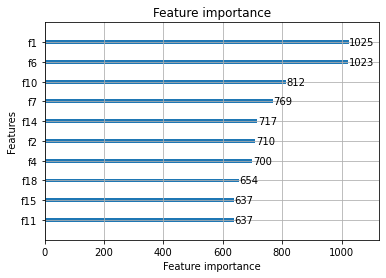

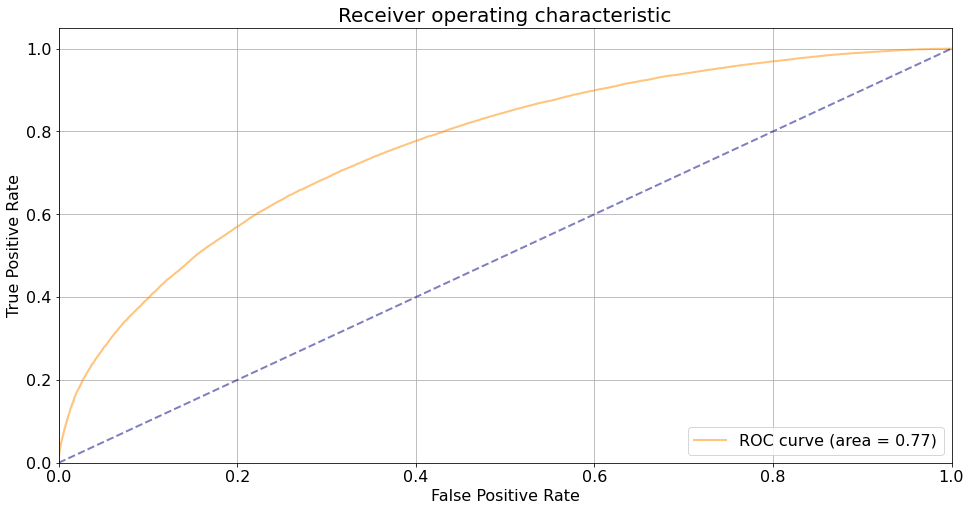

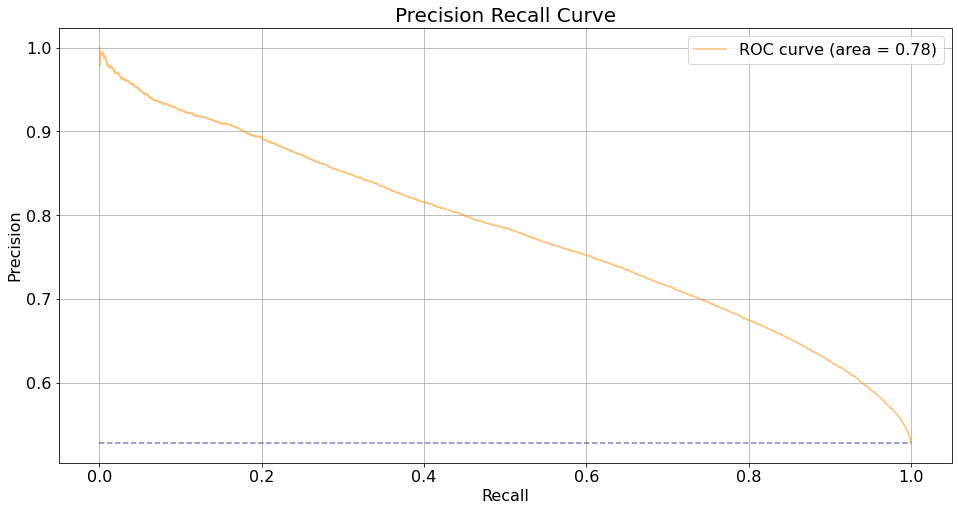

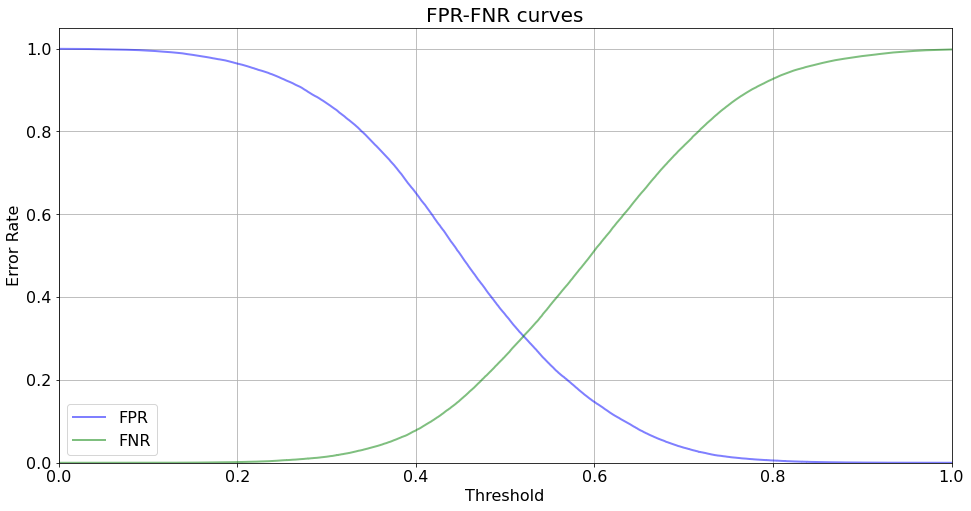

In [5]:
opt = obj.parameter_tuning('optuna_space', diagnostic= True)
obj.train(train_X, train_y)
obj.evaluate()


In [11]:
opt.trials

[FrozenTrial(number=0, value=0.3252160359691376, datetime_start=datetime.datetime(2020, 4, 28, 19, 15, 11, 328182), datetime_complete=datetime.datetime(2020, 4, 28, 19, 15, 22, 387578), params={'num_leaves': 44, 'max_bin': 254, 'lambda_l1': 5.893154810016104, 'lambda_l2': 0.03619192652051383, 'min_data_in_leaf': 356, 'boosting_type': 'goss', 'learning_rate': 0.15615819157003066, 'subsample_for_bin': 160000, 'feature_fraction': 0.9598944782267296, 'bagging_freq': 2}, distributions={'num_leaves': IntUniformDistribution(high=196, low=16, step=4), 'max_bin': IntUniformDistribution(high=255, low=254, step=1), 'lambda_l1': LogUniformDistribution(high=10.0, low=1e-08), 'lambda_l2': LogUniformDistribution(high=10.0, low=1e-08), 'min_data_in_leaf': IntUniformDistribution(high=500, low=20, step=1), 'boosting_type': CategoricalDistribution(choices=('gbdt', 'goss')), 'learning_rate': LogUniformDistribution(high=0.25, low=0.05), 'subsample_for_bin': IntUniformDistribution(high=300000, low=20000, st

Running 3 rounds of LGBM parameter optimisation using Hyperopt:
100%|██████████| 3/3 [00:45<00:00, 15.32s/it, best loss: 0.29723017508144123]
Model will be trained with best parameters obtained from Hyperopt ... 



Model trained with 53 estimators on the following parameters: 
{'bagging_freq': 2, 'boosting_type': 'gbdt', 'feature_fraction': 0.7581060118675438, 'lambda_l1': 0.7473985034480637, 'lambda_l2': 0.9474156743939212, 'learning_rate': 0.12372304135891532, 'max_bin': 254, 'min_data_in_leaf': 470, 'num_leaves': 60, 'objective': 'binary', 'subsample_for_bin': 220000, 'verbosity': 0, 'subsample': 0.8419830304755795, 'n_estimator': 53}
check pred
fpr, tpr, thresh check
fnr check
roc_auc check
precision recall check
pr_auc check
Plotting feature importances...


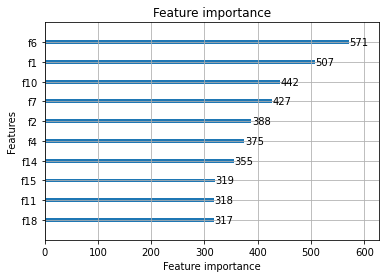

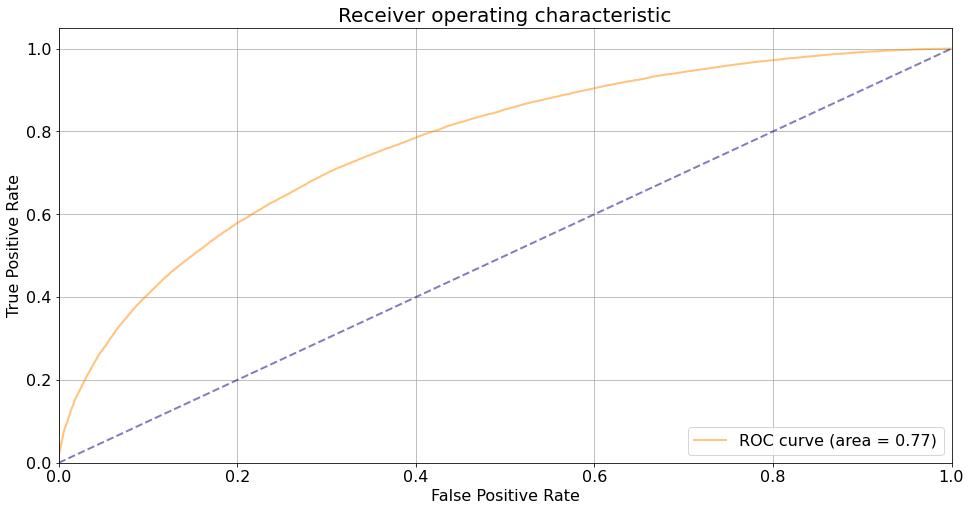

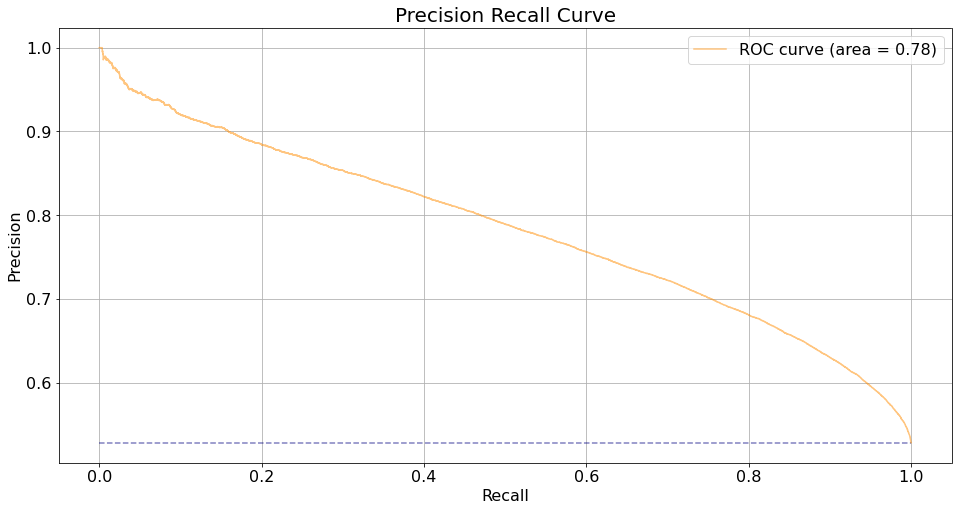

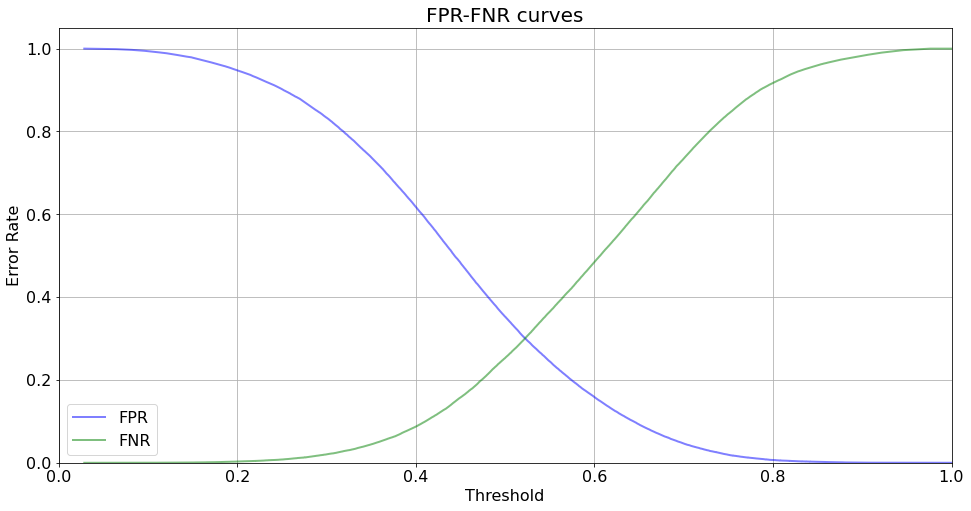

In [12]:
hopt = obj.parameter_tuning('hyperopt_space', diagnostic= True)
obj.train(train_X, train_y)
obj.evaluate()

In [0]:

best = param_df.loc[0, 'params']
best['n_estimator'] = int(param_df.loc[0, 'estimators'])
optim_type = param_df.loc[0, 'optim_type']

In [17]:
param_df = pd.read_csv(RESULT_PATH)
param_df.sort_values('loss', ascending = True, inplace = True)
param_df

,loss,params,iteration,estimators,train_time,optim_type
1,0.294431,"{'num_leaves': 120, 'max_bin': 254, 'lambda_l1...",2,412,48.321084,Optuna
0,0.325216,"{'num_leaves': 44, 'max_bin': 254, 'lambda_l1'...",1,51,11.460619,Optuna
2,0.333147,"{'num_leaves': 152, 'max_bin': 254, 'lambda_l1...",3,4,12.766713,Optuna


In [24]:
best = param_df.loc[0, 'params']




{'bagging_freq': 2,
 'boosting_type': 'goss',
 'feature_fraction': 0.9598944782267296,
 'lambda_l1': 5.893154810016104,
 'lambda_l2': 0.03619192652051383,
 'learning_rate': 0.15615819157003066,
 'max_bin': 254,
 'min_data_in_leaf': 356,
 'num_leaves': 44,
 'objective': 'binary',
 'subsample': 1,
 'subsample_for_bin': 160000,
 'verbosity': 0}